In [1]:
# import all we need to compute the mAP and produce some plots
# implementing mAP as documented in The PASCALVisual Object Classes (VOC) Challenge

import numpy as np
import pickle
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# grab all computed results 
# (.pkl format from "darknet_evaluation_post_inference.py")

input_path = "C:/Users/Legos/Documents/PhD/FARTS/BENCHMARK/RESULTS"
input_files = []

for file in os.listdir(input_path):
    if file.endswith(".pkl"):
        input_files.append(os.path.join(input_path,file))
        
input_files.sort()
print("Found {} evaluation files.".format(len(input_files)))
for d, dataset in enumerate(input_files):
    print(d, dataset)
    
use_state = 0

Found 87 evaluation files.
0 C:/Users/Legos/Documents/PhD/FARTS/BENCHMARK/RESULTS\bs10001_RESULTS.pkl
1 C:/Users/Legos/Documents/PhD/FARTS/BENCHMARK/RESULTS\bs10002_RESULTS.pkl
2 C:/Users/Legos/Documents/PhD/FARTS/BENCHMARK/RESULTS\bs10003_RESULTS.pkl
3 C:/Users/Legos/Documents/PhD/FARTS/BENCHMARK/RESULTS\bs10004_RESULTS.pkl
4 C:/Users/Legos/Documents/PhD/FARTS/BENCHMARK/RESULTS\bs10005_RESULTS.pkl
5 C:/Users/Legos/Documents/PhD/FARTS/BENCHMARK/RESULTS\bs1001_RESULTS.pkl
6 C:/Users/Legos/Documents/PhD/FARTS/BENCHMARK/RESULTS\bs1002_RESULTS.pkl
7 C:/Users/Legos/Documents/PhD/FARTS/BENCHMARK/RESULTS\bs1003_RESULTS.pkl
8 C:/Users/Legos/Documents/PhD/FARTS/BENCHMARK/RESULTS\bs1004_RESULTS.pkl
9 C:/Users/Legos/Documents/PhD/FARTS/BENCHMARK/RESULTS\bs1005_RESULTS.pkl
10 C:/Users/Legos/Documents/PhD/FARTS/BENCHMARK/RESULTS\bs101_RESULTS.pkl
11 C:/Users/Legos/Documents/PhD/FARTS/BENCHMARK/RESULTS\bs102_RESULTS.pkl
12 C:/Users/Legos/Documents/PhD/FARTS/BENCHMARK/RESULTS\bs103_RESULTS.pkl
13 C:/

In [3]:
with open(input_files[use_state], 'rb') as f:
    data = pickle.load(f)

"""
- data[0][0]
- training_data_&_training_state

- - data[0][1][0]
- - threshold (for first dataset)
  
- - - data[0][1][1][0 1  2    3   4   5                  6] 
- - - dataset_name,   GT, TP, FN, FP, Average Precision, Recall
"""
#examples:

all_training_states = []

for elem in data:
    all_training_states.append(int(elem[0].split(".")[0].split("_")[-1]))

all_training_states.sort()
print(all_training_states)

[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000]


The goal is to retrieve the mean Average Precision (mAP) over 13 confidence thresholds ranging from 0.2 to 0.8, classifying a correct detection centre as being within 10% (of the image width) euclidean distance to a ground truth detection, disregarding multiple detections of the same object as they would be suppressed by non-maxmimum suppresion at run-time. We use this adjusted metric from the original, as the actual intersection over union is secondary to the agreement of centres, as different methods have been used to assign bounding boxes. Synthetically generated bounding boxes are defined as the smallest retangle including all projected 2D keypoints in the rendered images, whereas hand annotated bounding boxes are fixed, square detections, as a custom written centre tracking tool (BlenderMotionExport) was used to semi-automatically produce these datasets.

As an example we will plot the precision over recall for these 13 thresholds for the first snapshot of the imported data, and compute the mAP, as in the official [scikit learn implementation](https://github.com/scikit-learn/scikit-learn/blob/baf0ea25d/sklearn/metrics/_ranking.py#L111)

(m)AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight:

$${AP} = \sum_n (R_n - R_{n-1}) P_n$$
    
where `P_n` and `R_n` are the precision and recall at the nth threshold. Using decreasing threshold values, the Recall $R_{n-1}$ at the first threshold is set to 0 as when the threshold is maximal, no detections are returned. Therefore, with no positives returned, the precision $P_{n-1}$ is by definition equal to 1.

*This implementation is not interpolated and is different from computing the area under the precision-recall curve with the trapezoidal rule, which uses linear interpolation and can be too optimistic.*

**Note:** this implementation is restricted to the binary classification task or multilabel classification task.

In [4]:
def clean_dataset_name(file_name,verbose=False):
    """
    return the name of the dataset wihtout the split extension
    """
    base_name = os.path.basename(file_name)
    dataset_name = base_name.split("_")[0][:-1]
    if verbose:
        print(dataset_name)
    return dataset_name

print("Found {} evaluation files.".format(len(input_files)))
    
all_nets_all_APs = []

prev_dataset = clean_dataset_name(input_files[0])
current_AP_group = []
training_datasets = [prev_dataset]

for use_state in range(len(input_files)):
    with open(input_files[use_state], 'rb') as f:
        data = pickle.load(f)

    all_training_states = []

    for elem in data:
        all_training_states.append(int(elem[0].split(".")[0].split("_")[-1]))

    all_training_states.sort()

    final_AP = []
    #print("\n",input_files[use_state])
    
    #all_nets_all_APs.append([input_files[use_state]])
    
    for dataset_idx in range(1,6):
        all_AP = []

        for model in data:
            #print("\nProducing AP plot for {}\n".format(model[0]))
            #print("With dataset {}\n".format(model[1][dataset_idx][0]))
            curve_coords = np.zeros([len(model[1:]),2])
            AP = 0
            R_n = 0
            for e, elem in reversed(list(enumerate(model[1:]))):
                curve_coords[e] = [elem[dataset_idx][6],elem[dataset_idx][5]]
                #print("thresh {}   Precision {}    Recall {}".format(elem[0],round(elem[dataset_idx][5],3),round(elem[dataset_idx][6],3)))
                AP += (elem[dataset_idx][6] - R_n) * elem[dataset_idx][5]
                R_n = elem[dataset_idx][6]

            #plt.plot(curve_coords[:,0],curve_coords[:,1])
            #print("AP: {}\n".format(AP))
            all_AP.append([model[1][dataset_idx][0],int(model[0].split(".")[0].split("_")[-1]),AP])

        #plt.show()

        all_AP.sort()
        #print(all_AP[-1])
        final_AP.append(all_AP[-1][-1])

    current_dataset = clean_dataset_name(input_files[use_state])
    if use_state == len(input_files)-1:
        current_AP_group.append(final_AP)
        all_nets_all_APs.append(current_AP_group)
        
    elif current_dataset != prev_dataset:
        prev_dataset = current_dataset
        all_nets_all_APs.append(current_AP_group)
        current_AP_group = []
        training_datasets.append(current_dataset)
        
    else:
        current_AP_group.append(final_AP)
    
        
"""
For the output shape we will produce the mean and standard deviation for each AP value for every model / dataset combination

        |                                 dataset
        |   base   base  bright bright  close  close  dark   drak  noisy  noisy
model   |   mean   std   mean   std     mean   std    mean   std   mean   std
____________________________________________________________________________________
bs1000  |
bs100   |
bs10    |
rb      |
ra      |
...     |

"""
output_AP = np.zeros([len(training_datasets),10])

dat = 0
for dataset_name, APs in zip(training_datasets,all_nets_all_APs):
    
    base_AP_mean = np.mean(np.array(APs)[:,0])
    bright_AP_mean = np.mean(np.array(APs)[:,1])
    close_AP_mean = np.mean(np.array(APs)[:,2])
    dark_AP_mean = np.mean(np.array(APs)[:,3])
    noisy_AP_mean = np.mean(np.array(APs)[:,4])
    
    base_AP_std = np.std(np.array(APs)[:,0])
    bright_AP_std = np.std(np.array(APs)[:,1])
    close_AP_std = np.std(np.array(APs)[:,2])
    dark_AP_std = np.std(np.array(APs)[:,3])
    noisy_AP_std = np.std(np.array(APs)[:,4])
    
    output_AP[dat] = [base_AP_mean, base_AP_std,
                    bright_AP_mean, bright_AP_std,
                    close_AP_mean, close_AP_std,
                    dark_AP_mean, dark_AP_std,
                    noisy_AP_mean, noisy_AP_std]
    
    dat += 1
    # COMBINE WITH DATASET NAMES FOR QUICK OVERVIEW
    # NOW THROW IT ALL INTO ONE PANDAS DATAFRAME

Found 87 evaluation files.


In [5]:
categories = [["base","base","bright","bright","close","close","dark","dark","noisy","noisy"],
              ["mean","std","mean","std","mean","std","mean","std","mean","std"]]

categories_tuples = list(zip(*categories))
columns = pd.MultiIndex.from_tuples(categories_tuples, names=["dataset","score"])
    
final_dataframe = pd.DataFrame(output_AP, index = training_datasets, columns=columns)

In [6]:
final_dataframe

dataset      base              bright               close                dark  \
score        mean       std      mean       std      mean       std      mean   
bs1000   0.998899  0.000663  0.954139  0.007751  0.764137  0.099988  0.952879   
bs100    0.999985  0.000010  0.971896  0.005423  0.533096  0.236077  0.951132   
bs10     0.999982  0.000006  0.982924  0.003758  0.844239  0.031983  0.939186   
ra       0.999978  0.000030  0.999968  0.000014  0.853503  0.003422  0.999947   
rb       0.999989  0.000006  0.987332  0.002325  0.661097  0.029698  0.770090   
rba      0.992458  0.001207  0.932712  0.008522  0.727274  0.070794  0.937097   
rbr      0.962785  0.004721  0.999991  0.000006  0.301432  0.007992  0.252127   
rc       0.842172  0.021024  0.454658  0.033011  0.833703  0.000275  0.402483   
rd       0.902126  0.007785  0.861027  0.065426  0.814589  0.012015  0.999952   
rn       0.955683  0.013280  0.961295  0.008348  0.690445  0.067912  0.906245   
sb1      0.989393  0.004528  0.979153  0.010526  0.919416  0.040182  0.982810   
sb5      0.979293  0.015966  0.934780  0.046355  0.836639  0.142646  0.954585   
sl       0.858237  0.064896  0.951850  0.008380  0.930355  0.020511  0.873380   
sls      0.935418  0.002491  0.939096  0.005604  0.899319  0.005599  0.969291   
sm       0.832022  0.056455  0.800875  0.057186  0.560886  0.219235  0.768238   
ss       0.771804  0.072291  0.355505  0.146437  0.891828  0.005012  0.744701   
tr       0.013769  0.020346  0.031899  0.032944  0.157002  0.109750  0.006536   
ts       0.001342  0.000150  0.014717  0.003731  0.039484  0.011882 -0.013137   

dataset               noisy            
score         std      mean       std  
bs1000   0.018360  0.920278  0.025788  
bs100    0.004832  0.925608  0.007299  
bs10     0.011350  0.877330  0.065420  
ra       0.000034  0.999975  0.000022  
rb       0.088170  0.831668  0.098753  
rba      0.018632  0.835780  0.052312  
rbr      0.078080  0.534953  0.103124  
rc       0.027076  0.636576  0.038203  
rd       0.000017  0.837906  0.019967  
rn       0.013539  0.999985  0.000017  
sb1      0.001046  0.921420  0.011364  
sb5      0.017729  0.889237  0.047093  
sl       0.083966  0.859181  0.018933  
sls      0.003659  0.822514  0.021982  
sm       0.105684  0.818777  0.048828  
ss       0.074078  0.573889  0.045476  
tr       0.005068  0.000627  0.000504  
ts       0.004909 -0.005869  0.004542

In [7]:
custom_name = "results_5_percent"

final_dataframe.to_csv(os.path.join(os.path.dirname(input_path),custom_name) + ".csv")

# IF the function below fails, this is likely due to exceeding the number of columns supported by HDF5 files!
# Restrict the number of simulated animals to < 20 if the goal is to train a DLC network

final_dataframe.to_hdf(
    os.path.join(os.path.dirname(input_path), custom_name) + ".h5",
    "df_with_missing",
    format="table",
    mode="w")
    

Plot the APs of models trained on sub-datasets on the 5 detection test cases

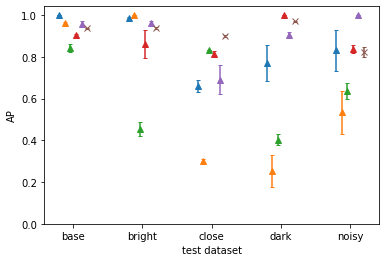

In [8]:
data = [[final_dataframe["base"]["mean"]["rb"],
         final_dataframe["bright"]["mean"]["rb"],
         final_dataframe["close"]["mean"]["rb"],
         final_dataframe["dark"]["mean"]["rb"],
         final_dataframe["noisy"]["mean"]["rb"]],
        
        [final_dataframe["base"]["mean"]["rbr"],
         final_dataframe["bright"]["mean"]["rbr"],
         final_dataframe["close"]["mean"]["rbr"],
         final_dataframe["dark"]["mean"]["rbr"],
         final_dataframe["noisy"]["mean"]["rbr"]],
        
        [final_dataframe["base"]["mean"]["rc"],
         final_dataframe["bright"]["mean"]["rc"],
         final_dataframe["close"]["mean"]["rc"],
         final_dataframe["dark"]["mean"]["rc"],
         final_dataframe["noisy"]["mean"]["rc"]],
        
        [final_dataframe["base"]["mean"]["rd"],
         final_dataframe["bright"]["mean"]["rd"],
         final_dataframe["close"]["mean"]["rd"],
         final_dataframe["dark"]["mean"]["rd"],
         final_dataframe["noisy"]["mean"]["rd"]],
        
        [final_dataframe["base"]["mean"]["rn"],
         final_dataframe["bright"]["mean"]["rn"],
         final_dataframe["close"]["mean"]["rn"],
         final_dataframe["dark"]["mean"]["rn"],
         final_dataframe["noisy"]["mean"]["rn"]],
        
        [final_dataframe["base"]["mean"]["sls"],
         final_dataframe["bright"]["mean"]["sls"],
         final_dataframe["close"]["mean"]["sls"],
         final_dataframe["dark"]["mean"]["sls"],
         final_dataframe["noisy"]["mean"]["sls"]]
       ]

X = np.arange(5) * 4
fig, ax = plt.subplots()

"""
ax = fig.add_axes([0,0,1,1])
ax.bar(X - 0.75, data[0], color = 'blue', width = 0.125)
ax.bar(X - 0.50, data[1], color = 'green', width = 0.125)
ax.bar(X - 0.25, data[2], color = 'red', width = 0.125)
ax.bar(X + 0.25, data[3], color = 'yellow', width = 0.125)
ax.bar(X + 0.50, data[4], color = 'black', width = 0.125)
ax.bar(X + 0.75, data[5], color = 'purple', width = 0.125)
"""

# base
x = np.array([1, 2, 3, 4, 5]) * 2.5 - 0.5 #0.3 0.1 0.1 0.3 0.5
y = [final_dataframe["base"]["mean"]["rb"],
     final_dataframe["bright"]["mean"]["rb"],
     final_dataframe["close"]["mean"]["rb"],
     final_dataframe["dark"]["mean"]["rb"],
     final_dataframe["noisy"]["mean"]["rb"]]

e = [final_dataframe["base"]["std"]["rb"],
         final_dataframe["bright"]["std"]["rb"],
         final_dataframe["close"]["std"]["rb"],
         final_dataframe["dark"]["std"]["rb"],
         final_dataframe["noisy"]["std"]["rb"]]

ax.errorbar(x, y, e, linestyle='None', marker='^', capsize=2)

#bright
x = np.array([1, 2, 3, 4, 5]) * 2.5 - 0.3
y = [final_dataframe["base"]["mean"]["rbr"],
     final_dataframe["bright"]["mean"]["rbr"],
     final_dataframe["close"]["mean"]["rbr"],
     final_dataframe["dark"]["mean"]["rbr"],
     final_dataframe["noisy"]["mean"]["rbr"]]

e = [final_dataframe["base"]["std"]["rbr"],
         final_dataframe["bright"]["std"]["rbr"],
         final_dataframe["close"]["std"]["rbr"],
         final_dataframe["dark"]["std"]["rbr"],
         final_dataframe["noisy"]["std"]["rbr"]]
ax.errorbar(x, y, e, linestyle='None', marker='^', capsize=2)

#close
x = np.array([1, 2, 3, 4, 5]) * 2.5 - 0.1
y = [final_dataframe["base"]["mean"]["rc"],
     final_dataframe["bright"]["mean"]["rc"],
     final_dataframe["close"]["mean"]["rc"],
     final_dataframe["dark"]["mean"]["rc"],
     final_dataframe["noisy"]["mean"]["rc"]]

e = [final_dataframe["base"]["std"]["rc"],
         final_dataframe["bright"]["std"]["rc"],
         final_dataframe["close"]["std"]["rc"],
         final_dataframe["dark"]["std"]["rc"],
         final_dataframe["noisy"]["std"]["rc"]]

ax.errorbar(x, y, e, linestyle='None', marker='^', capsize=2)

#dark
x = np.array([1, 2, 3, 4, 5]) * 2.5 + 0.1
y = [final_dataframe["base"]["mean"]["rd"],
     final_dataframe["bright"]["mean"]["rd"],
     final_dataframe["close"]["mean"]["rd"],
     final_dataframe["dark"]["mean"]["rd"],
     final_dataframe["noisy"]["mean"]["rd"]]

e = [final_dataframe["base"]["std"]["rd"],
         final_dataframe["bright"]["std"]["rd"],
         final_dataframe["close"]["std"]["rd"],
         final_dataframe["dark"]["std"]["rd"],
         final_dataframe["noisy"]["std"]["rd"]]

ax.errorbar(x, y, e, linestyle='None', marker='^', capsize=2)

#noisy
x = np.array([1, 2, 3, 4, 5]) * 2.5 + 0.3
y = [final_dataframe["base"]["mean"]["rn"],
     final_dataframe["bright"]["mean"]["rn"],
     final_dataframe["close"]["mean"]["rn"],
     final_dataframe["dark"]["mean"]["rn"],
     final_dataframe["noisy"]["mean"]["rn"]]

e = [final_dataframe["base"]["std"]["rn"],
         final_dataframe["bright"]["std"]["rn"],
         final_dataframe["close"]["std"]["rn"],
         final_dataframe["dark"]["std"]["rn"],
         final_dataframe["noisy"]["std"]["rn"]]

ax.errorbar(x, y, e, linestyle='None', marker='^', capsize=2)

#synth single
x = np.array([1, 2, 3, 4, 5]) * 2.5 + 0.5
y = [final_dataframe["base"]["mean"]["sls"],
     final_dataframe["bright"]["mean"]["sls"],
     final_dataframe["close"]["mean"]["sls"],
     final_dataframe["dark"]["mean"]["sls"],
     final_dataframe["noisy"]["mean"]["sls"]]

e = [final_dataframe["base"]["std"]["sls"],
         final_dataframe["bright"]["std"]["sls"],
         final_dataframe["close"]["std"]["sls"],
         final_dataframe["dark"]["std"]["sls"],
         final_dataframe["noisy"]["std"]["sls"]]

ax.errorbar(x, y, e, linestyle='None', marker='x', capsize=2)

plt.ylim(bottom=0)
ax.set_ylabel('AP')
ax.set_xlabel('test dataset')

#locs, labels = plt.xticks()  # Get the current locations and labels.
plt.xticks(np.array([1, 2, 3, 4, 5]) * 2.5, ['base', 'bright', 'close', 'dark', 'noisy'],
       rotation=0)  # Set text labels and properties.

plt.savefig("AP_sub_datasets_generalisation.svg")
plt.show()

In [9]:
plt.errorbar?

In [18]:
keys = ["base","bright","close","dark","noisy"]
mAPs_all = []

for dataset_name, APs in zip(training_datasets,all_nets_all_APs):
    
    if dataset_name == "rba" or dataset_name == "rb" or dataset_name == "bs1000" or dataset_name == "bs100" or dataset_name == "bs10" or dataset_name == "sb1" or dataset_name == "sb5":
        APs = np.array(APs)
        mask = np.ones(APs.shape[1], dtype=bool)
        mask[[0]] = False
        APs = APs[:,mask]

        mAPs_temp = np.mean(APs)
        temp_ind_std = np.std(APs,axis=(0))
        mAPs_temp_std = np.sqrt(np.sum(np.power(temp_ind_std,2),axis=0)/temp_ind_std.shape[0])
        mAPs_all.append([dataset_name, mAPs_temp, mAPs_temp_std])
        
       
    elif dataset_name == "rbr":
        APs = np.array(APs)
        mask = np.ones(APs.shape[1], dtype=bool)
        mask[[1]] = False
        APs = APs[:,mask]

        mAPs_temp = np.mean(APs)
        temp_ind_std = np.std(APs,axis=(0))
        mAPs_temp_std = np.sqrt(np.sum(np.power(temp_ind_std,2),axis=0)/temp_ind_std.shape[0])
        mAPs_all.append([dataset_name, mAPs_temp, mAPs_temp_std])
        
    elif dataset_name == "rc":
        APs = np.array(APs)
        mask = np.ones(APs.shape[1], dtype=bool)
        mask[[2]] = False
        APs = APs[:,mask]

        mAPs_temp = np.mean(APs)
        temp_ind_std = np.std(APs,axis=(0))
        mAPs_temp_std = np.sqrt(np.sum(np.power(temp_ind_std,2),axis=0)/temp_ind_std.shape[0])
        mAPs_all.append([dataset_name, mAPs_temp, mAPs_temp_std])

        
    elif dataset_name == "rd":
        APs = np.array(APs)
        mask = np.ones(APs.shape[1], dtype=bool)
        mask[[3]] = False
        APs = APs[:,mask]

        mAPs_temp = np.mean(APs)
        temp_ind_std = np.std(APs,axis=(0))
        mAPs_temp_std = np.sqrt(np.sum(np.power(temp_ind_std,2),axis=0)/temp_ind_std.shape[0])
        mAPs_all.append([dataset_name, mAPs_temp, mAPs_temp_std])

        
    elif dataset_name == "rn":
        APs = np.array(APs)
        mask = np.ones(APs.shape[1], dtype=bool)
        mask[[4]] = False
        APs = APs[:,mask]

        mAPs_temp = np.mean(APs)
        temp_ind_std = np.std(APs,axis=(0))
        mAPs_temp_std = np.sqrt(np.sum(np.power(temp_ind_std,2),axis=0)/temp_ind_std.shape[0])
        mAPs_all.append([dataset_name, mAPs_temp, mAPs_temp_std])

        
    elif dataset_name == "ra" or dataset_name == "ts" or dataset_name == "tr" or dataset_name == "sl" or dataset_name == "sm" or dataset_name == "ss"  or dataset_name == "sls":
        APs = np.array(APs)

        mAPs_temp = np.mean(APs)
        temp_ind_std = np.std(APs,axis=(0))
        mAPs_temp_std = np.sqrt(np.sum(np.power(temp_ind_std,2),axis=0)/temp_ind_std.shape[0])
        mAPs_all.append([dataset_name, mAPs_temp, mAPs_temp_std])
      
    print(mAPs_all[-1])

['bs1000', 0.8978585084558593, 0.0525827288910281]
['bs100', 0.8454328103388158, 0.1181506309917747]
['bs10', 0.9109197817839907, 0.036897047529704616]
['ra', 0.9706739821344625, 0.001530551144970637]
['rb', 0.8125466142987794, 0.06784843562696374]
['rba', 0.8582158731608062, 0.04518889513503772]
['rbr', 0.512824242109713, 0.06484070021515032]
['rc', 0.5839724691256865, 0.030513758716206586]
['rd', 0.8539120089596118, 0.03494359638470762]
['rn', 0.8784170779510876, 0.03550144959612968]
['sb1', 0.9506995067688278, 0.021538301859336407]
['sb5', 0.9038103068565276, 0.07910243580317144]
['sl', 0.8946005439290914, 0.049216348476169916]
['sls', 0.9131277228660605, 0.010635311528500653]
['sm', 0.7561594518741169, 0.11668314917550764]
['ss', 0.6675455716969003, 0.08276554905534565]
['tr', 0.0419666476061829, 0.05209661110875895]
['ts', 0.007307402743767427, 0.006322049350205261]


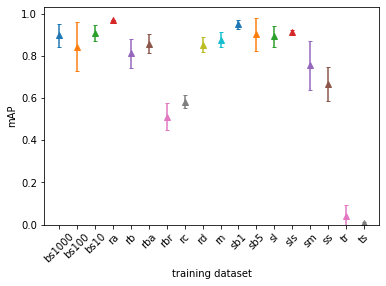

In [35]:
fig, ax = plt.subplots()
for x, data in enumerate(mAPs_all):
    ax.errorbar(x, data[1], data[2], linestyle='None', marker='^', capsize=2)
    
xticks = [x[0] for x in mAPs_all]
plt.xticks(np.arange(18), xticks,rotation=45)

plt.ylim(bottom=0)
ax.set_ylabel('mAP')
ax.set_xlabel('training dataset')

plt.savefig("mAP_all_training_datasets.svg")
plt.show()